# Vehicle Detection

Write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

### Step - 0: Load Libraries

In [1]:
%matplotlib inline
import os
import cv2
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from random import randint
from random import shuffle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from scipy import ndimage
from scipy.ndimage.measurements import label
from tensorflow.contrib.layers import flatten

# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Step - 1: Feature Extraction 

#### a. Read in  `vehicle` and `non-vehicle` images

* **a.1 object-detection-crowdai**

In [2]:
data_1 = pd.read_csv('object-detection-crowdai/labels.csv', header=0)
data_1['File_Path'] = 'object-detection-crowdai/' + data_1['Frame']
data_1 = data_1.drop('Preview URL', 1)
data_1 = data_1.drop('Frame', 1)
data_1['Label'] = data_1['Label'].str.lower()
data_1.columns = ['xmin','ymin','xmax','ymax', 'Label', 'File_Path']
data_1.head()

,xmin,ymin,xmax,ymax,Label,File_Path
0,785,533,905,644,car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,truck,object-detection-crowdai/1479498371963069978.jpg


In [3]:
# Summaries
print("Number of examples =", len(data_1))
print("Unique lables are", np.unique(data_1['Label']))
print("Number of cars =", len(data_1[data_1['Label']=='car']))
print("Number of trucks =", len(data_1[data_1['Label']=='truck']))
print("Number of pedestrians =", len(data_1[data_1['Label']=='pedestrian']))

Number of examples = 72064
Unique lables are ['car' 'pedestrian' 'truck']
Number of cars = 62570
Number of trucks = 3819
Number of pedestrians = 5675


* **a.2 object-dataset**

In [4]:
names = ['Frame', 'xmin','ymin','xmax','ymax', 'ind', 'Label','RM']
data_2 = pd.read_csv('object-dataset/labels.csv', delim_whitespace=True, names=names)
data_2['File_Path'] = 'object-dataset/' + data_2['Frame']
data_2 = data_2.drop('RM', 1)
data_2 = data_2.drop('Frame', 1)
data_2 = data_2.drop('ind', 1)
data_2.columns = ['xmin','ymin','xmax','ymax', 'Label', 'File_Path']
data_2.head()

,xmin,ymin,xmax,ymax,Label,File_Path
0,950,574,1004,620,car,object-dataset/1478019952686311006.jpg
1,1748,482,1818,744,pedestrian,object-dataset/1478019952686311006.jpg
2,872,586,926,632,car,object-dataset/1478019953180167674.jpg
3,686,566,728,618,truck,object-dataset/1478019953689774621.jpg
4,716,578,764,622,car,object-dataset/1478019953689774621.jpg


In [5]:
# Summaries
print("Number of examples =", len(data_2))
print("Unique lables are", np.unique(data_2['Label']))
print("Number of cars =", len(data_2[data_2['Label']=='car']))
print("Number of trucks =", len(data_2[data_2['Label']=='truck']))
print("Number of pedestrians =", len(data_2[data_2['Label']=='pedestrian']))

Number of examples = 93086
Unique lables are ['biker' 'car' 'pedestrian' 'trafficLight' 'truck']
Number of cars = 60788
Number of trucks = 3503
Number of pedestrians = 9866


* **a.3 Combine object-detection-crowdai and object-dataset**

In [ ]:
data_udacity = pd.concat([data_1, data_2]).reset_index()
data_udacity = data_udacity.drop('index', 1)
data_udacity.columns = ['xmin','ymin','xmax','ymax', 'Label', 'File_Path']
data_udacity.head()

In [ ]:
# Summaries
print("Number of examples =", len(data_udacity))
print("Unique lables are", np.unique(data_udacity['Label']))
print("Number of cars =", len(data_udacity[data_udacity['Label']=='car']))
print("Number of trucks =", len(data_udacity[data_udacity['Label']=='truck']))

* **a.4.1 Sample images from the udacity dataset**

In [ ]:
# Check number of examples
d_cars = data_udacity[(data_udacity['Label'] == 'car') | (data_udacity['Label'] == 'truck')].reset_index()
d_notcars = data_udacity[(data_udacity['Label'] != 'car') & (data_udacity['Label'] != 'truck')].reset_index()

print("Number of examples =", len(data_udacity)) 
print("Number of car examples =", len(d_cars)) 
print("Number of other examples =", len(d_notcars))                                                             

In [ ]:
cars = []
notcars = []

# Sample 3000 each from data_udacity
sample = 3000

for i in range(sample):
    index = randint(0, len(d_cars)-1)
    image = cv2.imread(d_cars['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_cars['ymin'][index]:d_cars['ymax'][index], 
                  d_cars['xmin'][index]:d_cars['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    cars.append(image)

for i in range(sample):
    index = randint(0, len(d_notcars)-1)
    image = cv2.imread(d_notcars['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_notcars['ymin'][index]:d_notcars['ymax'][index], 
                  d_notcars['xmin'][index]:d_notcars['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    notcars.append(image)

In [ ]:
# Summaries
print("Number of car examples =", len(cars)) 
print("Number of other examples =", len(notcars)) 

* **a.4.2 Sample train and test images separately from the two datasets**

In [6]:
# Use data_2 for train and data_1 for test
d_cars_train = data_2[(data_2['Label'] == 'car') | (data_2['Label'] == 'truck')].reset_index()
print("d_cars_train - ", len(d_cars_train))

d_cars_train = d_cars_train[(d_cars_train['xmax'] - d_cars_train['xmin'] > 0) &
                            (d_cars_train['ymax'] - d_cars_train['ymin'] > 0)].reset_index()
print("d_cars_train (after) - ", len(d_cars_train))

d_cars_test = data_1[(data_1['Label'] == 'car') | (data_1['Label'] == 'truck')].reset_index()
print("d_cars_test - ", len(d_cars_test))

d_cars_test = d_cars_test[(d_cars_test['xmax'] - d_cars_test['xmin'] > 0) &
                            (d_cars_test['ymax'] - d_cars_test['ymin'] > 0)].reset_index()
print("d_cars_test (after) - ", len(d_cars_test))

d_notcars_train= data_2[(data_2['Label'] != 'car') & (data_2['Label'] != 'truck')].reset_index()
print("d_notcars_train - ", len(d_notcars_train))

d_notcars_train = d_notcars_train[(d_notcars_train['xmax'] - d_notcars_train['xmin'] > 0) &
                            (d_notcars_train['ymax'] - d_notcars_train['ymin'] > 0)].reset_index()
print("d_notcars_train (after) - ", len(d_notcars_train))

d_notcars_test = data_1[(data_1['Label'] != 'car') & (data_1['Label'] != 'truck')].reset_index()
print("d_notcars_test - ", len(d_notcars_test))

d_notcars_test = d_notcars_test[(d_notcars_test['xmax'] - d_notcars_test['xmin'] > 0) &
                            (d_notcars_test['ymax'] - d_notcars_test['ymin'] > 0)].reset_index()
print("d_notcars_test (after) - ", len(d_notcars_test))

d_cars_train -  64291
d_cars_train (after) -  64291
d_cars_test -  66389
d_cars_test (after) -  66386
d_notcars_train -  28795
d_notcars_train (after) -  28795
d_notcars_test -  5675
d_notcars_test (after) -  5674


In [7]:
cars_train = []
cars_test = []
notcars_train = []
notcars_test = []

# Another 2000 images will be added to training set from KITTI and GTI sources
sample_train = 8000
sample_test = 2000

# Sample training data
for i in range(sample_train):
    index = randint(0, len(d_cars_train)-1)
    image = cv2.imread(d_cars_train['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_cars_train['ymin'][index]:d_cars_train['ymax'][index], 
                  d_cars_train['xmin'][index]:d_cars_train['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    cars_train.append(image)

for i in range(sample_train):
    index = randint(0, len(d_notcars_train)-1)
    image = cv2.imread(d_notcars_train['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_notcars_train['ymin'][index]:d_notcars_train['ymax'][index], 
                  d_notcars_train['xmin'][index]:d_notcars_train['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    notcars_train.append(image)    

# Sample testing data
for i in range(sample_test):
    index = randint(0, len(d_cars_test)-1)
    image = cv2.imread(d_cars_test['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_cars_test['ymin'][index]:d_cars_test['ymax'][index], 
                  d_cars_test['xmin'][index]:d_cars_test['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    cars_test.append(image)

for i in range(sample_test):
    index = randint(0, len(d_notcars_test)-1)
    image = cv2.imread(d_notcars_test['File_Path'][index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[d_notcars_test['ymin'][index]:d_notcars_test['ymax'][index], 
                  d_notcars_test['xmin'][index]:d_notcars_test['xmax'][index]]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    notcars_test.append(image)    
    
# Summaries
print("Number of car train examples =", len(cars_train)) 
print("Number of other train examples =", len(notcars_train)) 
print("Number of car test examples =", len(cars_test)) 
print("Number of other test examples =", len(notcars_test)) 

Number of car train examples = 8000
Number of other train examples = 8000
Number of car test examples = 2000
Number of other test examples = 2000


* **a.5.1 Sample images from vehicle and non-vehicles folder**

In [33]:
# Number of images in each folder
print ("KITTI_extracted:", len([img for img in os.listdir('vehicles/KITTI_extracted')]))
print ("GTI_Far:", len([img for img in os.listdir('vehicles/GTI_Far')]))
print ("GTI_Left:", len([img for img in os.listdir('vehicles/GTI_Left')]))
print ("GTI_MiddleClose:", len([img for img in os.listdir('vehicles/GTI_MiddleClose')]))
print ("GTI_Right:", len([img for img in os.listdir('vehicles/GTI_Right')]))
print ("non-vehicles/GTI:", len([img for img in os.listdir('non-vehicles/GTI')]))
print ("non-vehicles/Extras:", len([img for img in os.listdir('non-vehicles/Extras')]))

KITTI_extracted: 5967
GTI_Far: 835
GTI_Left: 910
GTI_MiddleClose: 420
GTI_Right: 665
non-vehicles/GTI: 3901
non-vehicles/Extras: 5069


In [ ]:
# Sample and append to cars and notcars data

# Sample 1000 cars
files = glob("vehicles/KITTI_extracted/*.png")
shuffle(files)
for i in range(600):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)

files = glob("vehicles/GTI_Far/*.png")
shuffle(files)
for i in range(100):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)

files = glob("vehicles/GTI_Left/*.png")
shuffle(files)
for i in range(100):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)

files = glob("vehicles/GTI_MiddleClose/*.png")
shuffle(files)
for i in range(100):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    
files = glob("vehicles/GTI_Right/*.png")
shuffle(files)
for i in range(100):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    
# Sample 1000 notcars
files = glob("non-vehicles/GTI/*.png")
shuffle(files)
for i in range(400):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars.append(image)

files = glob("non-vehicles/Extras/*.png")
shuffle(files)
for i in range(600):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars.append(image)

# Summaries    
print("Number of car examples =", len(cars)) 
print("Number of other examples =", len(notcars)) 

In [ ]:
# Look at few images
plt.subplot(1, 2, 1)
plt.imshow(cars[101])  
plt.subplot(1, 2, 2)
plt.imshow(notcars[101])

* **a.5.2 Sample images from vehicle and non-vehicles folder but only append to train**

In [8]:
# Sample and append to cars_train and notcars_train data

# Sample 2000 cars
files = glob("vehicles/KITTI_extracted/*.png")
shuffle(files)
for i in range(1200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars_train.append(image)

files = glob("vehicles/GTI_Far/*.png")
shuffle(files)
for i in range(200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars_train.append(image)

files = glob("vehicles/GTI_Left/*.png")
shuffle(files)
for i in range(200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars_train.append(image)

files = glob("vehicles/GTI_MiddleClose/*.png")
shuffle(files)
for i in range(200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars_train.append(image)
    
files = glob("vehicles/GTI_Right/*.png")
shuffle(files)
for i in range(200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars_train.append(image)
    
# Sample 2000 notcars
files = glob("non-vehicles/GTI/*.png")
shuffle(files)
for i in range(800):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars_train.append(image)

files = glob("non-vehicles/Extras/*.png")
shuffle(files)
for i in range(1200):
    image = cv2.imread(files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars_train.append(image)

# Summaries
print("Number of car train examples =", len(cars_train)) 
print("Number of other train examples =", len(notcars_train)) 
print("Number of car test examples =", len(cars_test)) 
print("Number of other test examples =", len(notcars_test)) 

Number of car train examples = 10000
Number of other train examples = 10000
Number of car test examples = 2000
Number of other test examples = 2000


#### b. Extract color features

* **b.1 Color histogram features**

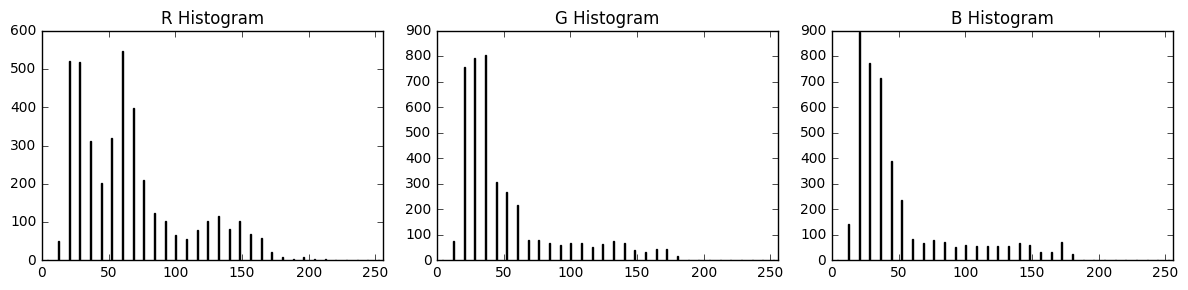

In [9]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Check
rh, gh, bh, bincen, feature_vec = color_hist(cars_train[101], nbins=32, bins_range=(0, 256))

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

* **b.2 Explore color spaces**

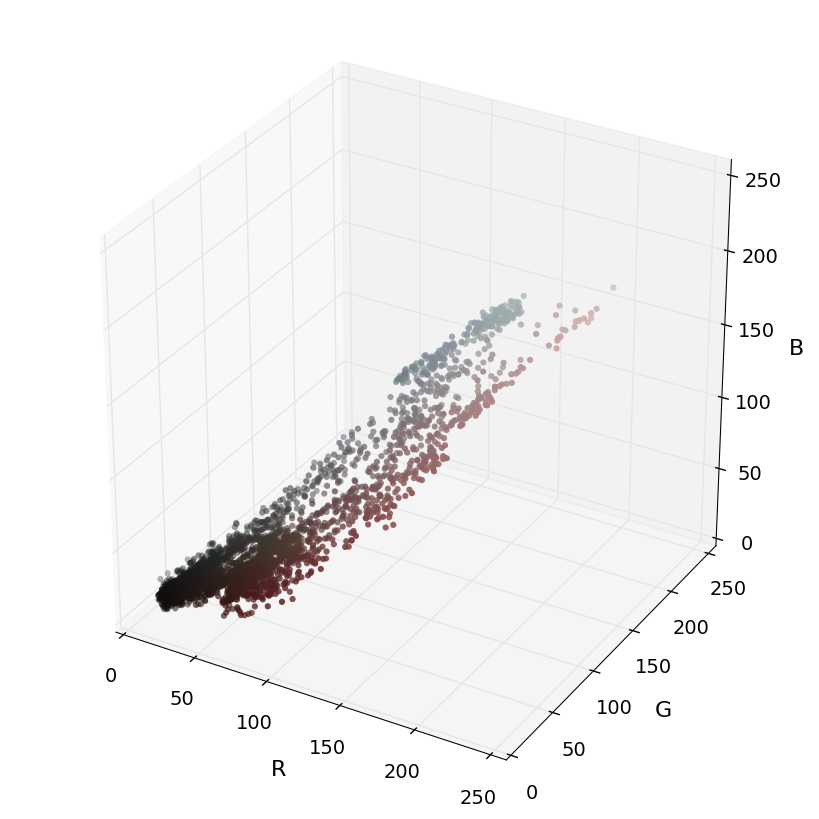

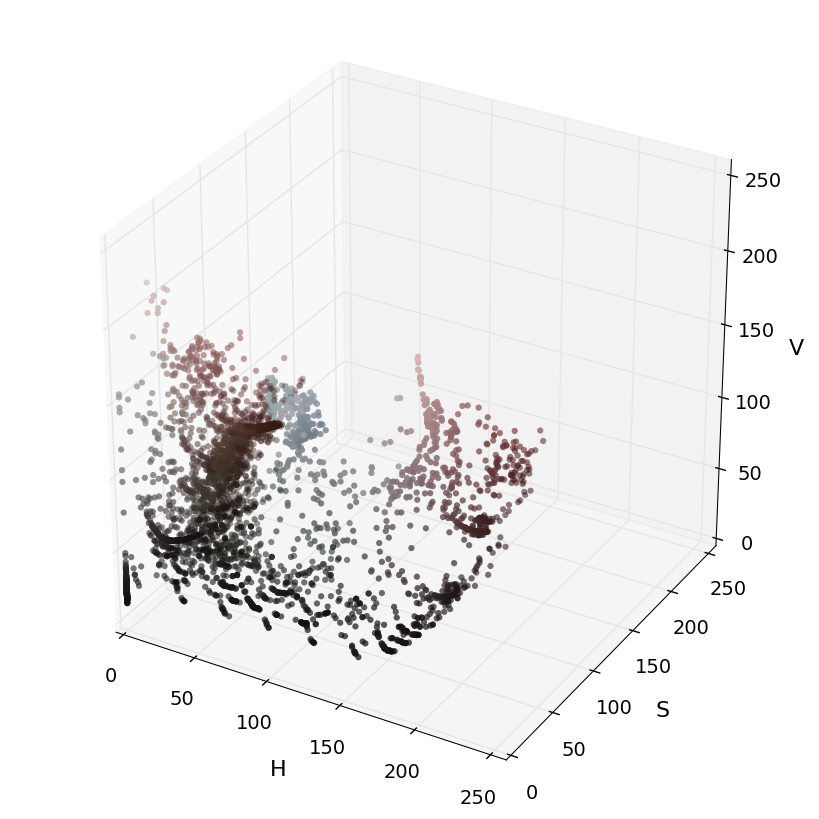

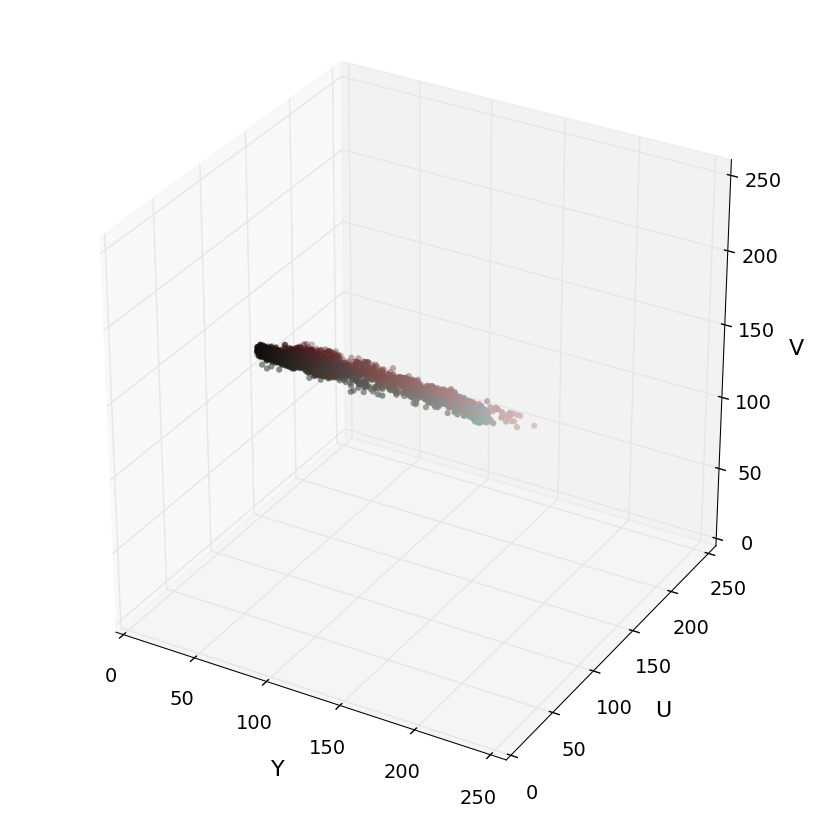

In [10]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Convert image to desired color space(s)
img_small_RGB = cars_train[101]
img_small_HSV = cv2.cvtColor(img_small_RGB, cv2.COLOR_RGB2HSV)
img_small_YUV = cv2.cvtColor(img_small_RGB, cv2.COLOR_RGB2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))

* **b.3 Spatial binning of color**

In [11]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Check 
features = bin_spatial(cars_train[101], color_space='RGB', size=(32, 32))
print (features.shape)

(3072,)


#### c. Extracted HOG features

* **c.1 scikit-image HOG**

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

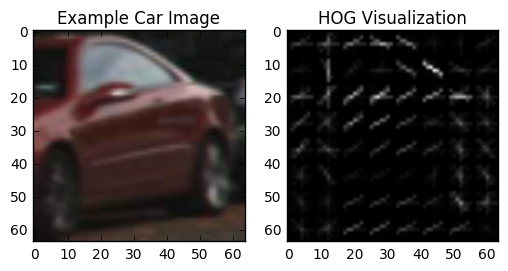

In [13]:
# Read in the image
image = cv2.cvtColor(cars_train[101], cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(cars_train[101])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

* **c.2 Combine and normalize features**

In [14]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

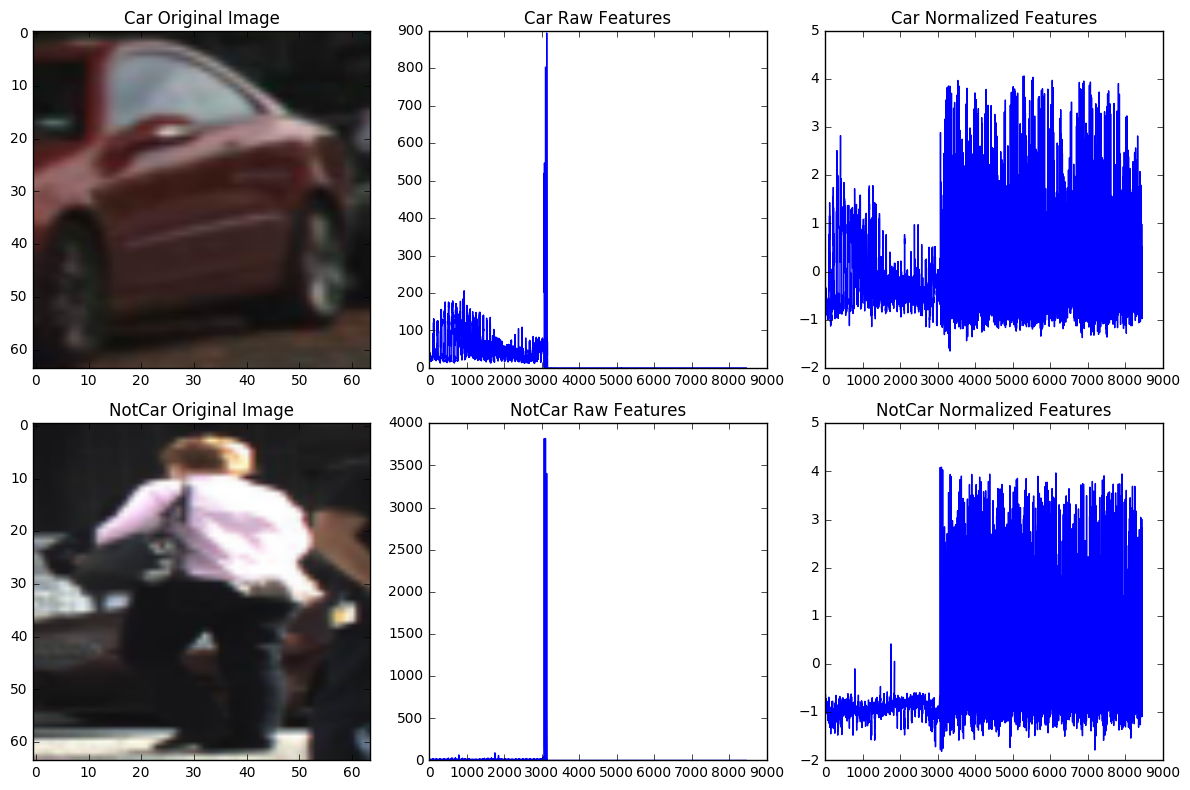

In [16]:
# Tune the parameters
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 32
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars_train[101:110], color_space='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_features = extract_features(notcars_train[101:110], color_space='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
#y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

fig = plt.figure(figsize=(12, 8))
# Plot one for car
plt.subplot(231)
plt.imshow(cars_train[101])
plt.title('Car Original Image')
plt.subplot(232)
plt.plot(X[0])
plt.title('Car Raw Features')
plt.subplot(233)
plt.plot(scaled_X[0])
plt.title('Car Normalized Features')

# Plot one for notcar
plt.subplot(234)
plt.imshow(notcars_train[101])
plt.title('NotCar Original Image')
plt.subplot(235)
plt.plot(X[10])
plt.title('NotCar Raw Features')
plt.subplot(236)
plt.plot(scaled_X[10])
plt.title('NotCar Normalized Features')
fig.tight_layout()

### Step - 2: Build a Classifier

#### a. Prep training data

* **a.1 Sampling strategy 1**

In [ ]:
# Tune the parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 32
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [ ]:
# Summaries
print("Number of training examples =", len(X_train)) 
print("Number of testing examples =", len(X_test)) 

* **a.2 Sampling strategy 2**

In [27]:
# Tune the parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 32
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Train
car_train_features = extract_features(cars_train, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_train_features = extract_features(notcars_train, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((car_train_features, notcar_train_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
X_train = X_scaler.transform(X)
y_train = np.hstack((np.ones(len(car_train_features)), np.zeros(len(notcar_train_features))))

# Test
car_test_features = extract_features(cars_test, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_test_features = extract_features(notcars_test, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((car_test_features, notcar_test_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
X_test = X_scaler.transform(X)
y_test = np.hstack((np.ones(len(car_test_features)), np.zeros(len(notcar_test_features))))

# Summaries
print("Number of training examples =", len(X_train), len(y_train)) 
print("Number of testing examples =", len(X_test), len(y_test)) 

Number of training examples = 20000 20000
Number of testing examples = 4000 4000


#### b. Classifiers

In [ ]:
# Test multiple classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(5),
    LinearSVC(),
    SVC(),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=10, min_samples_split=100),
    RandomForestClassifier(max_depth=5, min_samples_split=300, n_estimators=25),
    MLPClassifier(),
    AdaBoostClassifier(learning_rate = 0.01),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


# iterate over classifiers
for name, clf in zip(names, classifiers):
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print('Test Accuracy of', name, '=', clf.score(X_test, y_test), '; cost =', round(t2-t, 2))

* **b.1 Final classifier**

In [32]:
# Use Neural Net for further testing
clf = MLPClassifier(verbose=True)
#clf = LinearSVC()
t = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Test Accuracy of Neural Net =', clf.score(X_test, y_test), '; cost =', round(t2-t, 2))

Iteration 1, loss = 0.23215625
Iteration 2, loss = 0.04933634
Iteration 3, loss = 0.01955952
Iteration 4, loss = 0.00815554
Iteration 5, loss = 0.00242532
Iteration 6, loss = 0.00107418
Iteration 7, loss = 0.00078624
Iteration 8, loss = 0.00062796
Iteration 9, loss = 0.00051999
Iteration 10, loss = 0.00043604
Iteration 11, loss = 0.00036090
Iteration 12, loss = 0.00031061
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Test Accuracy of Neural Net = 0.90975 ; cost = 54.79


#### c. LeNet-5

* **c.1 Sampling strategy 1**

In [ ]:
# Normalize to 0.1 - 0.9
image = []
cars_small = []
notcars_small = []
for img in cars:
    cars_small.append(cv2.resize(img, (32,32)))
for img in notcars:
    notcars_small.append(cv2.resize(img, (32,32)))  
image = np.append(cars_small, notcars_small, axis=0)
image_normalize = image / 255 * 0.8 + 0.1
lable = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(image_normalize, lable, test_size=0.2, random_state=rand_state)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_state)

* **c.2 Sampling strategy 2**

In [20]:
# Normalize to 0.1 - 0.9
train = []
cars_train_small = []
notcars_train_small = []
test = []
cars_test_small = []
notcars_test_small = []

for img in cars_train:
    cars_train_small.append(cv2.resize(img, (32,32)))
for img in notcars_train:
    notcars_train_small.append(cv2.resize(img, (32,32)))  
train = np.append(cars_train_small, notcars_train_small, axis=0)
train_normalize = train / 255 * 0.8 + 0.1
train_lable = np.hstack((np.ones(len(cars_train)), np.zeros(len(notcars_train))))

for img in cars_test:
    cars_test_small.append(cv2.resize(img, (32,32)))
for img in notcars_test:
    notcars_test_small.append(cv2.resize(img, (32,32)))  
test = np.append(cars_test_small, notcars_test_small, axis=0)
test_normalize = test / 255 * 0.8 + 0.1
test_lable = np.hstack((np.ones(len(cars_test)), np.zeros(len(notcars_test)))) 
                
X_test, y_test = test_normalize, test_lable
                       
# Split up data into randomized training and validation sets
rand_state = np.random.randint(0, 100)
X_train, X_validation, y_train, y_validation = train_test_split(train_normalize, train_lable, 
                                                                test_size=0.2, 
                                                                random_state=rand_state)
# Summaries
print("Number of training examples =", len(X_train), len(y_train)) 
print("Number of validation examples =", len(X_validation), len(y_validation)) 
print("Number of testing examples =", len(X_test), len(y_test))                                               

Number of training examples = 16000 16000
Number of validation examples = 4000 4000
Number of testing examples = 4000 4000


Model saved


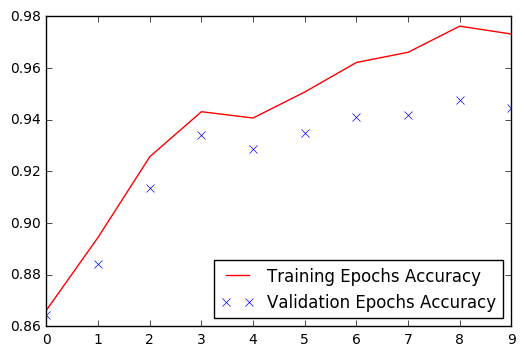

In [23]:
# Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 2)

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
mu = 0
sigma = 0.1
strides = 1
k = 2
rate = 0.001

# Implement LeNet-5
def conv2d(x, W, b, strides):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def LeNet(x):        
    conv1 = conv2d(x, tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)), 
                   tf.Variable(tf.zeros(6)), strides)
    conv1 = maxpool2d(conv1, k)
    conv2 = conv2d(conv1, tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
                   tf.Variable(tf.zeros(16)), strides)
    conv2 = maxpool2d(conv2, k)    
    fc11 = flatten(conv2)
    fc11 = tf.add(tf.matmul(fc11, tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))),
                            tf.Variable(tf.zeros(120)))
    fc11 = tf.nn.relu(fc11)
    fc12 = tf.add(tf.matmul(fc11, tf.Variable(tf.truncated_normal(shape=(120, 32), mean = mu, stddev = sigma))),
                            tf.Variable(tf.zeros(32)))
    fc12 = tf.nn.relu(fc12)
    out = tf.add(tf.matmul(fc12, tf.Variable(tf.truncated_normal(shape=(32, 2), mean = mu, stddev = sigma))),
                           tf.Variable(tf.zeros(2)))
    return out

# Training Pipeline
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Model Evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    train_accuracy = []
    validation_accuracy = []
    
    for i in range(EPOCHS):
        X_data, y_data = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_data[offset:end], y_data[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        train_accuracy.append(evaluate(X_train, y_train))
        validation_accuracy.append(evaluate(X_validation, y_validation))
        
    saver.save(sess, 'LeNet')
    print("Model saved") 

    plt.plot(range(EPOCHS), train_accuracy, 'r', label='Training Epochs Accuracy')
    plt.plot(range(EPOCHS), validation_accuracy, 'x', label='Validation Epochs Accuracy')
    plt.legend(loc=4)
    plt.show()  

In [24]:
# Evaluate the Model on test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy of LeNet = {:.5f}".format(test_accuracy))

Test Accuracy of LeNet = 0.84450


### Step - 3: Sliding Window Search

#### a. Prep training data

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [ ]:
image = mpimg.imread('img105.jpeg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

labels = label(heatmap)
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

### Step - 4: Video Implementation

In [ ]:
test_output = 'test_video_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
test_clip = clip1.fl_image(process_video) 
%time test_clip.write_videofile(test_output, audio = False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [ ]:
project_output = 'project_video_output_p5.mp4'
clip1 = VideoFileClip('project_video_output_p4.mp4')
project_clip = clip1.fl_image(process_video) 
%time project_clip.write_videofile(project_output, audio = False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))